**kaggle data to download**

In [1]:
# ! pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !kaggle competitions download -c severstal-steel-defect-detection

100% 1.57G/1.57G [00:17<00:00, 114MB/s] 
100% 1.57G/1.57G [00:17<00:00, 97.7MB/s]


In [2]:
# !unzip severstal-steel-defect-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/99f75320d.jpg  
  inflating: train_images/99f9d2375.jpg  
  inflating: train_images/99fd3c6f5.jpg  
  inflating: train_images/9a016fe15.jpg  
  inflating: train_images/9a064450d.jpg  
  inflating: train_images/9a08c2783.jpg  
  inflating: train_images/9a18e4457.jpg  
  inflating: train_images/9a1f7c238.jpg  
  inflating: train_images/9a2523ce9.jpg  
  inflating: train_images/9a3e774ff.jpg  
  inflating: train_images/9a5e9e77c.jpg  
  inflating: train_images/9a5f7a855.jpg  
  inflating: train_images/9a62177bb.jpg  
  inflating: train_images/9a67575cf.jpg  
  inflating: train_images/9a6ac5406.jpg  
  inflating: train_images/9a70057c0.jpg  
  inflating: train_images/9a72fd89e.jpg  
  inflating: train_images/9a75974ba.jpg  
  inflating: train_images/9a762b892.jpg  
  inflating: train_images/9a7b2f3af.jpg  
  inflating: train_images/9a7b427b4.jpg  
  inflating: train_images/9a81a8056.jpg  
  inflating: train_images

# learning first
> https://www.kaggle.com/code/gpiosenka/steel-defect-classification-f1score-86

In [31]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


## 自定義回調概念
這個筆記本實現了一個自定義回調來調整訓練期間的學習率。
回調有一個參數 dwell。 如果 dwell 設置為 True，則回調會監控驗證丟失。 它會跟踪您運行時迄今為止達到的最低驗證損失
通過每個時期並將其存儲為最低損失，並將該時期的權重存儲為最佳權重。 在一個紀元結束時，將該紀元的驗證損失與最低損失進行比較。 如果當前時期結束時的驗證損失小於最低損失，則它成為最低損失，並且當前時期的權重成為最佳權重


<br>
<br>

如果當前紀元結束時的驗證損失大於最低損失
這意味著你已經移動到 N 空間中的一個位置（N 是可訓練參數的數量
在比位置更不利（成本更高）的驗證成本函數表面上
在由最佳權重定義的 Nspace 中。 因此，為什麼要將模型權重降低到這個程度
有利位置？ 最好將模型權重重置為最佳權重，然後降低學習率並運行更多時期。 新的學習率設置為 new_lr=current_lr * factor，其中 factor 是回調實例化中用戶指定的參數。 默認情況下它設置為 .04，默認情況下駐留設置為 True。

<br>
<br>



在訓練結束時，回調總是返回權重設置為
最好的重量。 回調提供了一個功能，它會定期查詢用戶
繼續並可選擇手動指定新的學習率或停止訓練。
在培訓期間，回調提供了有關改進百分比的有用信息
每個時期的驗證損失。 這對於決定何時停止訓練或手動指定新的學習率很有用。



### load the data

In [32]:
df = pd.read_csv("train.csv")

df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [33]:
# drop EncodedPixels
df= df.drop("EncodedPixels",axis=1)
df.columns =['filepaths','labels']
df.head()

,filepaths,labels
0,0002cc93b.jpg,1
1,0007a71bf.jpg,3
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,4
4,0014fce06.jpg,3


In [34]:
img_dir = 'train_images'

df['filepaths'] = df['filepaths'].apply(lambda x:os.path.join(img_dir,x))
df['labels'] = df['labels'].apply(lambda x:str(x))
df.head()

,filepaths,labels
0,train_images/0002cc93b.jpg,1
1,train_images/0007a71bf.jpg,3
2,train_images/000a4bcdd.jpg,1
3,train_images/000f6bf48.jpg,4
4,train_images/0014fce06.jpg,3


user:a little data analysic 

In [35]:
labels_len = np.unique(df['labels'])
labels_len

array(['1', '2', '3', '4'], dtype=object)

3    5150
1     897
4     801
2     247
Name: labels, dtype: int64


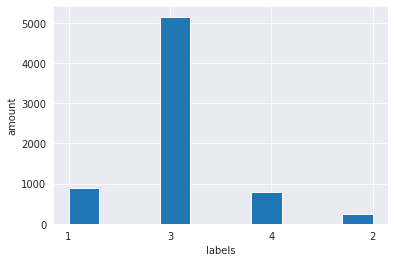

In [36]:
# type(df['labels'])
count = df['labels'].value_counts()
print(count)
plt.hist(df['labels'])
plt.xlabel("labels")
plt.ylabel("amount")
plt.show()



### split datasets

In [37]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print(f"train_df:{train_df.shape},test_df:{test_df.shape},valid_df:{valid_df.shape}")


train_df:(5676, 2),test_df:(710, 2),valid_df:(709, 2)


因為df的分佈太大，所以定義一個函數去限制在數據集採樣中，各個類別的數據都存在
set max samples=1000. Set min_samples = 197 so all classes are included in the dataset.¶

In [38]:
max_samples = 1000
min_samples = 247 

def trim(df,max_samples,min_samples,column):
  df=df.copy()
  classes=df[column].unique()
  class_count=len(classes)
  length=len(df)

  print("dataframe 初始化长度为",length,"with",class_count,'classes')
  groups=df.groupby(column)    
  trimmed_df = pd.DataFrame(columns = df.columns)
  groups=df.groupby(column)

  for label in df[column].unique():
    group = groups.get_group(label)
    count = len(group)
    if count > max_samples:
      sampled_group = group.sample(n=max_samples,random_state=123,axis=0)
      trimmed_df = pd.concat([trimmed_df,sampled_group],axis=0)
    else:
      if count >= min_samples:
        sampled_group = group 
        trimmed_df = pd.concat([trimmed_df,sampled_group],axis=0)

  print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
  classes = trimmed_df[column].unique()
  class_count = len(classes)
  length=len(trimmed_df)
  print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
  return trimmed_df, classes, class_count

max_samples = 1000
min_samples = 197
column='labels'
train_df,classes,class_count = trim(train_df,max_samples,min_samples,column)

dataframe 初始化长度为 5676 with 4 classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  197
the trimmed dataframe now is of length  2556  with  4  classes


In [39]:
!pwd

/content


**定義一個函數去平衡labels train_df**
现在让我们用增强图像来平衡数据集。下面的平衡函数为每个类创建所需数量的增强图像，并更新df以包括修剪图像和标签以及增强图像


In [40]:
import albumentations as A

def balance(df,n,column,working_dir,img_size):
  def get_augmented_image(image):
    width = int(image.shape[1]*.8)
    height = int(image.shape[0]*0.8)
    transform = A.Compose([
        A.HorizontalFlip(p=.5),
        A.Rotate(limit=30, p=.25),
        A.RandomBrightnessContrast(p=.5),
        A.RandomGamma(p=.5),
        A.RandomCrop(width=width, height=height, p=.25) 
    ])
    return transform(image=image)['image']
  def dummy(image):
    return image 

  df = df.copy()
  print("初始的圖片尺寸",len(df))
  # directory to store augmented images
  aug_dir = os.path.join(working_dir,'aug')
  if os.path.isdir(aug_dir):
    # start with an empty directory
    shutil.rmtree(aug_dir)
  os.mkdir(aug_dir)
  for label in df[column].unique():
    dir_path = os.path.join(aug_dir,label)
    # make class directory within aug directory 
    os.mkdir(dir_path)
  # create and store the augmented iamges 
  total = 0 
  groups = df.groupby(column)
  # for every class
  for label in df[column].unique():
    # a dataframe holding only rows with the specified label
    group = groups.get_group(label)
    # detemine how many samples there are in this class 
    sample_count = len(group)
    if sample_count<n:
      # if the class has less than target nu,ber of images 
      aug_img_count = 0 
      # number of augmented.images to create 
      delta = n - sample_count 
      # define where to write the images 
      target_dir = os.path.join(aug_dir,label)
      desc = f"augmenting class {label}"
      for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
        j= i % sample_count
        img_path=group['filepaths'].iloc[j]
        img=cv2.imread(img_path)
        img=get_augmented_image(img)
        fname=os.path.basename(img_path)
        fname='aug' +str(i) +'-' +fname
        dest_path=os.path.join(target_dir, fname)                
        cv2.imwrite(dest_path, img)
        aug_img_count +=1
      total +=aug_img_count
  print('Total Augmented images created= ', total)
  # create aug_df and merge with train_df to create composite training set ndf 
  aug_fpaths = []
  aug_labels = []
  classlist = sorted(os.listdir(aug_dir))
  for klass in classlist:
    classpath = os.path.join(aug_dir,klass)
    flist = sorted(os.listdir(classpath))
    for f in flist:
      fpath = os.path.join(classpath,f)
      aug_fpaths.append(fpath)
      aug_labels.append(klass)
  Fseries = pd.Series(aug_fpaths,name='filepaths')
  Lseries = pd.Series(aug_labels,name='labels')
  aug_df = pd.concat([Fseries,Lseries],axis=1)
  df = pd.concat([df,aug_df],axis=0).reset_index(drop=True)
  print('Length of augmented dataframe is now ', len(df))
  return df 

n=1000
working_dir=r'working/'
img_size = (100,625)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)


初始的圖片尺寸 2556


augmenting class 2: 100%|██████████████████████████████████████████████████████████| 803/803 [00:14<00:00, 54.35files/s]

Total Augmented images created=  1444
Length of augmented dataframe is now  4000


In [41]:
train_df.value_counts()

filepaths                           labels
train_images/0002cc93b.jpg          1         1
working/aug/1/aug201-e52f2f2de.jpg  1         1
working/aug/1/aug190-21fb2df8d.jpg  1         1
working/aug/1/aug191-1f117b19e.jpg  1         1
working/aug/1/aug192-7749df027.jpg  1         1
                                             ..
train_images/880f0b8cc.jpg          3         1
train_images/8866a93f6.jpg          4         1
train_images/8898932bd.jpg          4         1
train_images/88df5f0d8.jpg          3         1
working/aug/4/aug99-cb93f342e.jpg   4         1
Length: 4000, dtype: int64

https://www.kaggle.com/code/gpiosenka/steel-defect-classification-f1score-86#Create-a-function-to-show-example-training-images

create the train_gen,test_gen ,final_test_gen and valid_gen 


In [42]:
def make_gens(batch_size,ycol,train_df,test_df,valid_df,img_size):
  trgen = ImageDataGenerator(horizontal_flip=True)
  t_and_v_gen = ImageDataGenerator()
  msg = '{0:70s} for train generator'.format(" ")
  print(msg,'\r',end='')
  train_gen = trgen.flow_from_dataframe(
      train_df,
      x_col='filepaths',
      y_col = ycol,
      target_size = img_size,
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle=True,
      batch_size = batch_size)
  msg = "{0:70s} for valid generator".format("")
  print(msg,'\r',end="")
  valid_gen = t_and_v_gen.flow_from_dataframe(
      valid_df,
      x_col = 'filepaths',
      y_col = ycol,
      target_size = img_size,
      class_mode = 'categorical',
      color_mode = 'rgb',
      shuffle=True,
      batch_size=batch_size,

  )
  # for test gen we want to calculate the batch size and test steps 
  # such that h_size Xtest_shapes =number of samples in test set 
  length = len(test_df)
  test_batch_size = sorted([int(length/n)
   for n in range(1,length+1) if length %n ==0
   and length /n <=80],reverse=True)[0]

  test_steps = int(length/test_batch_size)
  msg='{0:70s} for test generator'.format(' ')
  print(msg, '\r', end='') 
  test_gen = t_and_v_gen.flow_from_dataframe(
      test_df,
      x_col='filepaths',
      y_col =ycol,
      shuffle=True,
      batch_size = test_batch_size
  )
  classes = list(train_gen.class_indices.keys())
  class_indices = list(train_gen.class_indices.values())
  class_count = len(classes) 
  labels = test_gen.labels 
  print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
  return train_gen, test_gen, valid_gen, test_steps


bs =30 
ycols = 'labels'
train_gen,test_gen,valid_gen,test_steps = make_gens(
    bs,ycols,train_df,test_df,valid_df,img_size
)

Found 4000 validated image filenames belonging to 4 classes.
Found 709 validated image filenames belonging to 4 classes.
Found 710 validated image filenames belonging to 4 classes.
test batch size:  71   test steps:  10  number of classes :  4


create a function to calculate the F1 score metric 

In [43]:
def F1_score(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_positives/(predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives+K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

create a model using transfer learning with EffientNet
> NOTE:experts advise you make the base model intitally not trainable when you do transfer learning.Then train for some number of epochs then fine tune model by making base model trainable and run more epochs,i have found this to be wrong
> making the base model trainable from the outset leads to faster convergence and a lower validation loss for the same number of total epochs .insure you initialize the transfer model with imagenet weights

In [44]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [45]:
def make_model(img_size,lr,mod_num=3):
  img_shape = (img_size[0],img_size [1],3)
  if mod_num ==0:
    base_model =tf.keras.applications.efficientnet.EfficientNetB0(
         include_top=False,
         weights = 'imagenet',
         input_shape = img_shape,
         pooling='max' )
    msg = 'Created EfficientNetB0 model'
  elif mod_num==3:
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(
        include_top=False,
        weights = 'imagenet',
        input_shape=img_shape,
        pooling='max'
    )
    msg = 'Created EfficientNetB3 model'
  elif mod_num ==5:
    base_model = tf.keras.applications.efficientnet.EfficientNetB5(
        include_top=False,
        weights = 'imagenet',
        input_shape=img_shape,
        pooling='max'
    )
    msg = 'Created EfficientNetB5 model'
  else:
    base_model = tf.keras.applications.efficientnet.EfficientNetB7(
        include_top=False,
        weights = 'imagenet',
        input_shape=img_shape,
        pooling='max'
    )
    msg = 'Created EfficientNetB7 model'
  
  base_model.trainable=False 
  x = base_model.output 
  x = BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001)(x)
  x = Dense(
      256,
      kernel_regularizer=regularizers.l2(l=0.016),
      activity_regularizer = regularizers.l1(0.006),
      bias_regularizer = regularizers.l1(0.004),
      activation='relu')(x)
  x = Dropout(rate=0.4,seed=123)(x)
  output = Dense(class_count,activation='softmax')(x)
  model = Model(inputs = base_model.input,outputs=output)

  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC']) 
  msg=msg + f' with initial learning rate set to {lr}'
  print_in_color(msg)
  
  return model
lr = 0.001 
model = make_model(img_size,lr)

Created EfficientNetB3 model with initial learning rate set to 0.001



create a custom Keras callback to continue and optionally set LR or halt training 

In [46]:
# class LR_ASK(keras.callbacks.Callback):
#   def __init__(self,model,epochs,ask_epoch,dwell=True,factor=0.4):
#     super(LR_ASK,self).__init__()
#     self.model = model 
#     self.ask_epoch = ask_epoch 
#     self.epochs = epochs 
#     self.ask=True 
#     self.lowest_vloss = np.inf 
#     self.lowest_aloss = np.inf 

#     self.best_weights = self.model.get_weights()

#     self.best_epoch = 1 
#     self.plist=[]
#     self.alist=[]
#     self.dwell = dwell 
#     self.factor = factor 
#   def get_list(self):
#     return self.plist,self.alist 
  
#   def on_train_begin(self,logs=None):
#     if self.ask_epoch == 0:
#       print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
#       self.ask_epoch=1
#     if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
#       print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
#       self.ask=False # do not query the user
#     if self.epochs == 1:
#       self.ask=False # running only for 1 epoch so do not query user
#     else:
#       msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
#       print_in_color(msg)
#       msg = 'Enter H to halt training or enter an integer for how many more epochs then be asked again'
#       print_in_color(msg)
#       if self.dwell:
#         msg='learning rate will be automatically adjusted during training'
#         print_in_color(msg)
#     self.start_time = time.time()

#   def on_train_end(self,logs=None):
#     msg = f"loading model with weights from epoch{self.best_epoch}"
#     print_in_color(msg)
#     self.model.set_weights (self.best_weights)
#     tr_duration = time.time() - self.start.time()
#     hours = tr_duration //3600
#     minutes = (tr_duration - (hours * 3600)) // 60
#     seconds = tr_duration - ((hours * 3600) + (minutes * 60))
#     msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
#     print_in_color(msg)

#   def on_epoch_end(self,epoch,logs=None):
#     vloss = logs.get('val_loss')
#     aloss = logs.get('loss')
#     if epoch>0:
#       deltav = self.lowest_vloss - vloss 
#       pimprov = (deltav /self.lowest_vloss)*100
#       self.plist.append(pimprov)
#       deltaa=self.lowest_aloss-aloss
#       aimprov=(deltaa/self.lowest_aloss) * 100
#       self.alist.append(aimprov)
#     else:
#       pimprov = 0.0 
#       aimprov = 0.0 
#     if vloss < self.lowest_vloss:
#       self.lowest_vloss = vloss 
#       self.best_weights = self.model.get_weights()
#       self.best_epoch = epoch +1 
#       msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
#       print_in_color(msg)

#     else:
#       pimprov = abs(pimprov)
#       msg = f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
#       print_in_color(msg)
#       if self.dwell:
#         # if dwell is True when the validatin loss increases the learning 
#         # rate is automatically reduced and model weights are set to best weights 
#         lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))# get the current learning rate 
#         new_lr = lr * self.factor
#         msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
#         print_in_color(msg)
#         tf.keras.backend.set_value(self.model.optimzer.lr,new_lr)
#         self.model.set_weights(self.best_weights)

#     if aloss<self.lowest_aloss:
#       self.lowest_aloss = aloss 
#     if self.ask:
#       if epoch +1 ==self.ask_epoch:
#         msg = 'press enter to continue or enter a commnet below'
#         print_in_color(msg)
#         comment = input(" ")
#         if comment !='':
#           comment = 'User comment:'+comment
#         msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
#         print_in_color(msg) # cyan foreground
#         ans=input()
#         if ans =='H' or ans =='h'or ans =='0':
#           msg = f'you enter {ans},training halted on epoch{epoch}+1 due to user input'
#           print_in_color(msg)
#           self.model.stop_training = True 
#         else:
#           self.ask_epoch+= int(ans)
#           if self.ask_epoch > self.epochs:
#             print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
#           else:
#             msg = f'you entered {ans} training will continue to epoch{self.ask_epoch}'
#             print_in_color(msg)
#             if self.dwell== False:
#               lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
#               msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
#               print_in_color(msg) # cyan foreground
#               ans=input(' ') 
#               if ans =='':
#                 msg = f'keeping current lr of {lr:7.5f}'
#                 print_in_color(msg)
#               else:
#                 new_lr = float(ans)
#                 tf.keras.backend.set_value(self.model.optimizer.lr,new_lr)
#                 msg = f'changing lr to {ans}'
#                 print_in_color(msg)
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground



instantiate custom callback

In [47]:
epochs = 50
ask_epoch = 5 
ask = LR_ASK(model,epochs,ask_epoch)
callbacks =[ask]


## train the model
Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning. The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights. I have done a lot of testing running both ways hand have always found this to be true¶


In [48]:
 history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 7.2972 - accuracy: 0.7315 - F1_score: 0.7224 - auc: 0.9085
 validation loss of  6.2010 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

134/134 [==============================] - 914s 7s/step - loss: 7.2972 - accuracy: 0.7315 - F1_score: 0.7224 - auc: 0.9085 - val_loss: 6.2010 - val_accuracy: 0.7574 - val_F1_score: 0.7480 - val_auc: 0.9266
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 5.1723 - accuracy: 0.7993 - F1_score: 0.8002 - auc: 0.9487
 validation loss of  4.5283 is 26.9755 % below lowest loss, saving weights from epoch 2   as best weights

134/134 [==============================] - 747s 6s/step - loss: 5.1723 - accuracy: 0.7993 - F1_scor

## define a function to plot the training data 

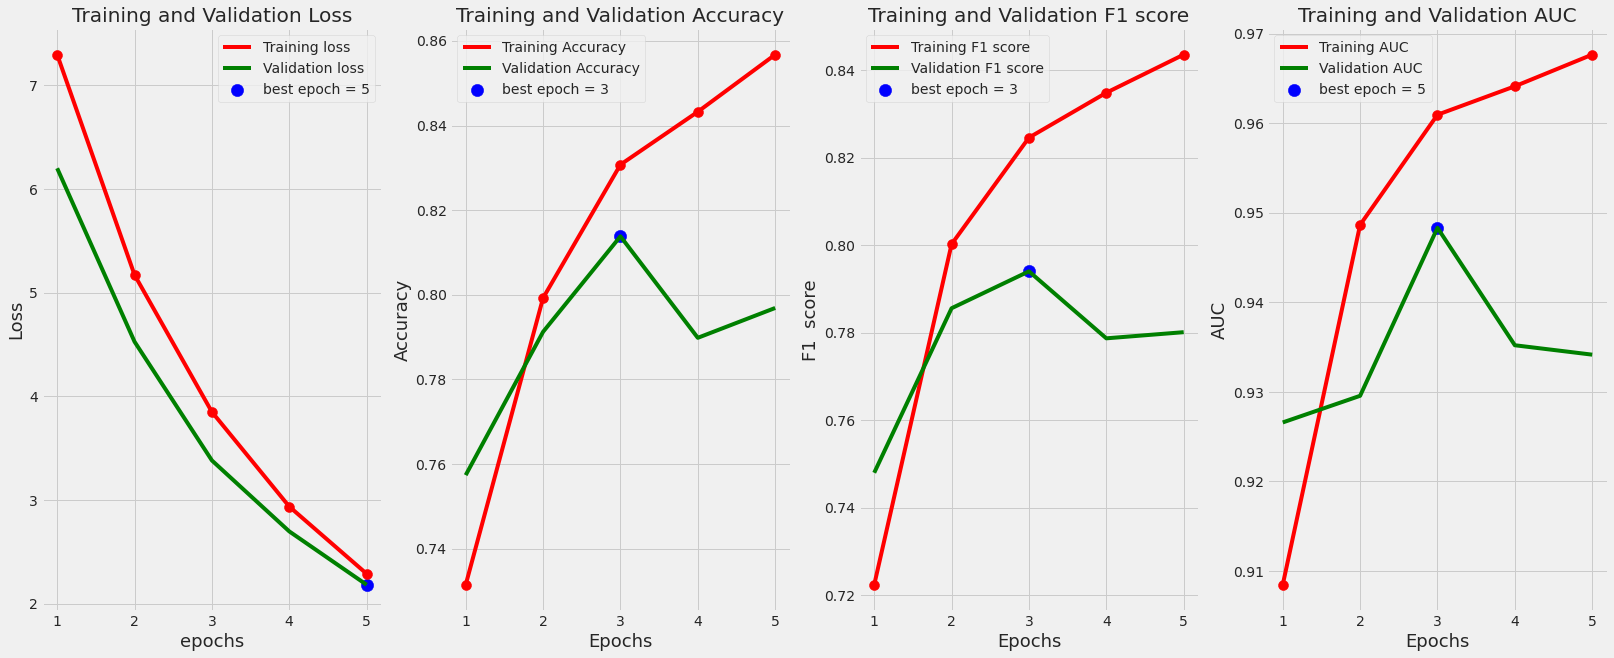

In [57]:
def tr_plot(tr_data):
  start_epoch = 0 
  # plot the training and validation data 
  tacc = tr_data.history['accuracy']
  tloss = tr_data.history['loss']
  vacc = tr_data.history['val_accuracy']
  vloss = tr_data.history['val_loss']

  tf1 = tr_data.history['F1_score']
  vf1 =tr_data.history['val_F1_score']
  tauc = tr_data.history['auc']
  vauc = tr_data.history['val_auc']
  epoch_count = len(tacc)+start_epoch 
  epochs = []
  for i in range(start_epoch,epoch_count):
    epochs.append(i+1)
  index_loss = np.argmin(vloss)
  # val_lowest = vloss[index_loss]
  # index_acc = np.argmax(vacc)
  # acc_highest = vacc[index_acc]
  # auc_index = np.argmax(vauc)
  val_lowest=vloss[index_loss]
  index_acc=np.argmax(vacc)
  acc_highest=vacc[index_acc]
  auc_index=np.argmax(vauc)
  val_highest_auc=vauc[auc_index]

  plt.style.use('fivethirtyeight')
  sc_label = 'best epoch = '+str(index_loss+1+start_epoch)
  vc_label = 'best epoch = '+str(index_acc+1+start_epoch)
  auc_label = 'best epoch = '+str(acc_highest+1+start_epoch)
  fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
  axes[0].plot(epochs,tloss, 'r', label='Training loss')
  axes[0].plot(epochs,vloss,'g',label='Validation loss' )
  axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
  axes[0].scatter(epochs, tloss, s=100, c='red')    
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('epochs', fontsize=18)
  axes[0].set_ylabel('Loss', fontsize=18)
  axes[0].legend()
  axes[1].plot (epochs,tacc,'r',label= 'Training Accuracy')
  axes[1].scatter(epochs, tacc, s=100, c='red')
  axes[1].plot (epochs,vacc,'g',label= 'Validation Accuracy')
  axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs', fontsize=18)
  axes[1].set_ylabel('Accuracy', fontsize=18)
  axes[1].legend()
  axes[2].plot (epochs,tf1,'r',label= 'Training F1 score')    
  axes[2].plot (epochs,vf1,'g',label= 'Validation F1 score')
  index_tf1 = np.argmax(tf1)
  tf1max = tf1[index_tf1]
  index_vf1 = np.argmax(vf1)
  vf1max = vf1[index_vf1]
  axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
  axes[2].scatter(epochs, tf1, s=100, c='red')
  axes[2].set_title('Training and Validation F1 score')
  axes[2].set_xlabel('Epochs', fontsize=18)
  axes[2].set_ylabel('F1  score', fontsize=18)
  axes[2].legend()
  axes[3].plot(epochs,tauc, 'r', label='Training AUC')
  axes[3].plot(epochs,vauc,'g',label='Validation AUC' )
  axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
  axes[3].scatter(epochs, tauc, s=100, c='red')    
  axes[3].set_title('Training and Validation AUC')
  axes[3].set_xlabel('Epochs', fontsize=18)
  axes[3].set_ylabel('AUC', fontsize=18)
  axes[3].legend()
  plt.tight_layout    
  plt.show()
  return 
tr_plot(history)

define a function to save training data to a csv file 

In [58]:
def save_history_to_csv(history,working_dir):
  csvpath = os.path.join(working_dir,'history.csv')
  trdict = history.history 
  keys = list(trdict.keys())
  df = pd.DataFrame()
  for key in keys:
    data = list(trdict[key])
    df[key] = data 
  df.to_csv(csvpath,index=False)
  msg = f'training data has been saved to {csvpath}'
  print_in_color(msg)
   
save_history_to_csv(history,working_dir)

training data has been saved to working/history.csv



make predictions on the test set 

10/10 [==============================] - 107s 11s/step
there were 465 errors in 710 tests for an accuracy of  34.51



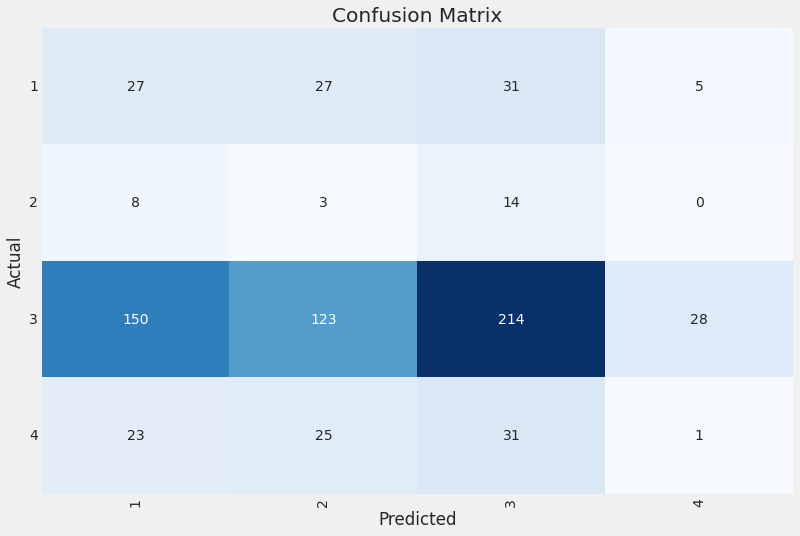

Classification Report:
----------------------
               precision    recall  f1-score   support

           1     0.1298    0.3000    0.1812        90
           2     0.0169    0.1200    0.0296        25
           3     0.7379    0.4155    0.5317       515
           4     0.0294    0.0125    0.0175        80

    accuracy                         0.3451       710
   macro avg     0.2285    0.2120    0.1900       710
weighted avg     0.5556    0.3451    0.4116       710



In [60]:
def predictor(test_gen):
  y_pred = []
  error_list = []
  error_pred_list =[]
  y_true = test_gen.labels 
  classes = list(test_gen.class_indices.keys())
  class_count = len(classes)
  errors = 0 
  preds = model.predict(test_gen,verbose=1)
  tests = len(preds)
  for i,p in enumerate(preds):
    pred_index = np.argmax(p)
    true_index = test_gen.labels[i]
    if pred_index != true_index:
      errors = errors +1 
      file = test_gen.filenames[i]
      error_list.append(file)
      error_class = classes[pred_index]
      error_pred_list.append(error_class)
    y_pred.append(pred_index)
  acc = (1-errors/tests)*100
  msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
  print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
  ypred = np.array(y_pred)
  ytrue = np.array(y_true)
  f1score = f1_score(y_true,ypred,average='weighted')*100 
  if class_count <=30:
    cm = confusion_matrix(y_true,ypred)
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,vmin=0,fmt='g',cmap='Blues',cbar=False)
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
  clr = classification_report(y_true,y_pred,target_names =classes,digits=4)
  print("Classification Report:\n----------------------\n", clr)
  return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

save the model 

In [61]:
def save_model(subject,classes,img_size,f1score,working_dir):
  name=subject + '-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
  save_id=f'{name}-{f1score:5.2f}.h5'
  model_save_loc=os.path.join(working_dir, save_id)
  model.save(model_save_loc)
  msg= f'model was saved as {model_save_loc}'
  print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
  

In [62]:
subejct = 'steel defects'
save_model(subejct,classes,img_size,f1score,working_dir)

model was saved as working/steel defects-4-(100 X 625)-41.16.h5



make a dataframe of the test images and make a test generator

In [65]:
def make_test_gen(testdir,img_size):
  flist=sorted(os.listdir(testdir))
  filepaths=[]
  for f in tqdm(flist, ncols=120, colour='blue', unit='files'):
    fpath=os.path.join(testdir,f)
    filepaths.append(fpath)
  Fseries=pd.Series(filepaths, name='filepaths')
  df=pd.concat([Fseries], axis=1)    
  gen=ImageDataGenerator()
  test_gen=gen.flow_from_dataframe(df, x_col='filepaths', y_col=None, class_mode=None, target_size=img_size, shuffle=False)
  return test_gen

testdir = 'test_images'
test_gen= make_test_gen(testdir, img_size)
    

100%|████████████████████████████████████████████████████████████████████████| 5506/5506 [00:00<00:00, 425050.39files/s]

Found 5506 validated image filenames.


make predictions on test set and generate submission.csv file

In [66]:
preds = model.predict(test_gen,verbose=1)
print(preds.shape)

173/173 [==============================] - 876s 5s/step
(5506, 4)


In [67]:
files = []
dummy = []
klasses = []
for i,p in enumerate(preds):
  index = np.argmax(p)
  klass = int(classes[index])
  klasses.append(klass)
  file = os.path.basename(test_gen.filenames[i])
  files.append(file)
  dummy.append('1 409600')
Fseries=pd.Series(files, name='ImageId')
Dseries=pd.Series(dummy, name='EncodedPix')
Lseries=pd.Series(klasses, name='ClassId')
submission_df=pd.concat([Fseries, Dseries, Lseries], axis=1)
csvpath= os.path.join(working_dir, 'submission.csv')
submission_df.to_csv(csvpath, index=False)
df=pd.read_csv(csvpath)
print (df.head())


         ImageId EncodedPix  ClassId
0  0000f269f.jpg   1 409600        1
1  000ccc2ac.jpg   1 409600        1
2  002451917.jpg   1 409600        4
3  003c5da97.jpg   1 409600        4
4  0042e163f.jpg   1 409600        4


# learning second
https://www.kaggle.com/code/myroofs/severstal-steel-defect-detection-with-xception

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import warnings
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import keras
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.applications.xception import Xception, preprocess_input
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [4]:
df = pd.read_csv("train.csv")
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

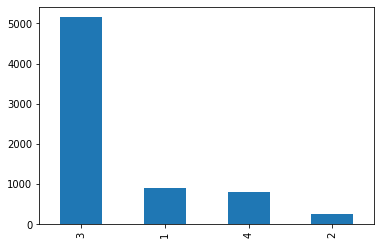

In [5]:
df['ClassId'].value_counts().plot(kind='bar')
df['ClassId'].value_counts()

In [6]:
l1 = []
l2 = []
# Tqdm 是一个快速，可扩展的Python进度条，可以在 Python 长循环中添加一个进度提示信息，用户只需要封装任意的迭代器 tqdm(iterator)。
for img,ClassId ,EncodedPixels in tqdm(df.values):
  image = cv2.imread('train_images/{}'.format(img),cv2.IMREAD_COLOR)
  image = cv2.resize(image,(120,120))
  l1.append(image)
  l2.append(ClassId)

100%|██████████| 7095/7095 [01:06<00:00, 106.98it/s]


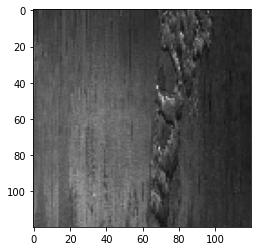

In [7]:
plt.imshow(l1[10])

In [8]:
encoder = LabelEncoder()
X = np.array(l1)
X = X/255 

y = encoder.fit_transform(l2)
y = to_categorical(y)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(5676, 120, 120, 3) (1419, 120, 120, 3) (5676, 4) (1419, 4)


In [10]:
base_model = tf.keras.applications.Xception(input_shape=(120,120,3),include_top=False,weights='imagenet')


83683744/83683744 [==============================] - 1s 0us/step


In [12]:
# freezing layers 
for layer in base_model.layers[:-5]:
  # print(layer)
  layer.trainable=False

In [13]:
# build model
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [15]:
def f1_score(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val


In [16]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score
]

In [18]:
lrd = ReduceLROnPlateau(
    monitor='val_loss',
    patience=20,
    verbose=1,
    factor=0.5,
    min_lr = 1e-10
)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1,patience=20)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=metrics)

In [ ]:
history = model.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),batch_size=128,verbose=1,callbacks=[lrd,mcp,es])

Epoch 1/15
25/45 [===============>..............] - ETA: 4:38 - loss: 0.9150 - accuracy: 0.8489 - precision: 0.7444 - recall: 0.6025 - auc: 0.8814 - f1_score: 0.6520

In [ ]:
def train_val_plot(history):
  fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(20,5))
  fig.subtitle('model metrics visualization')
  # acc
  ax1.plot(range(1,len(history.history['acc'])+1),history.history['acc'])
  ax1.plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'])
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['training', 'validation'])


  # loss 
  ax2.plot(range(1,len(history.history['loss'])+1),history.history['loss'])
  ax2.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['training', 'validation'])
  # precision
  ax3.plot(range(1,len(history.history['precision'])+1),history.history['precision'])
  ax3.plot(range(1, len(history.history['val_precision']) + 1), history.history['val_precision'])
  ax3.set_title('History of Precision')
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('Precision')
  ax3.legend(['training', 'validation'])
  # f1 
  ax4.plot(range(1,len(history.history['f1_score'])+1),history.history['f1_score'])
  ax4.plot(range(1, len(history.history['val_f1_score']) + 1), history.history['val_f1_score'])
  ax4.set_title('History of f1_score')
  ax4.set_xlabel('Epochs')
  ax4.set_ylabel('F1 score')
  ax4.legend(['training', 'validation'])
  # final show 
  plt.show()
train_val_plot(history)
